In [1]:
# # # importing data onto Google Colab
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
import math
import h5py
import numpy as np
import netCDF4 as nc
from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random
import copy

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from functools import partial
from torch.cuda import max_memory_allocated, set_device, manual_seed_all

2.1.0a0+29c30b1


In [3]:
# importing data onto Google Colab
# from google.colab import drive
# drive.mount('/content/drive/')

# CNN

### Prepare Data for CNN in PyTorch

In [4]:
ds2 = xr.open_dataset("Detrended_SST.nc", decode_times=False)
ds2

<xarray.Dataset> Size: 2GB
Dimensions:  (lat: 192, lon: 288, time: 7400)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 59kB 0 366 731 1096 1461 ... 25568 25933 26298 26664
Data variables:
    SST      (time, lat, lon) float32 2GB ...

In [5]:
PRECT = pd.read_csv('Detrended_PRECT_reordered.csv')
PRECT = PRECT.set_index(['simulation', 'year', 'region'])
PRECT.head(10)

PRECT
simulation year region            
1001.001   1940 Central   1.696816
                North    -4.384861
                South     2.359652
           1941 Central   7.414276
                North    15.164542
                South    -0.276591
           1942 Central   1.005114
                North    -0.246500
                South     1.693045
           1943 Central  -5.456921

In [6]:
y = PRECT.to_numpy()
y.shape

(22200, 1)

In [7]:
y = y.reshape(-1, 3)
y = y[:, 2]
y.shape

(7400,)

In [8]:
y_reshaped = y.reshape(100, 74, 1)
y_reshaped.shape

(100, 74, 1)

In [9]:
X = ds2['SST'].to_numpy()
X.shape

(7400, 192, 288)

In [10]:
X_reshaped = X.reshape(100, 74, 192, 288)
X_reshaped.shape

(100, 74, 192, 288)

In [11]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [12]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.1, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.1/.9, random_state=49)

#Create Dataloader Objects for PyTorch
BATCH_SIZE = 32

X_train = from_numpy(X_train).float()
y_train = from_numpy(y_train).float()
X_val = from_numpy(X_val).float()
y_val = from_numpy(y_val).float()
X_test = from_numpy(X_test).float()
y_test = from_numpy(y_test).float()

print("After train/val/test split, before reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

X_train = X_train.view(-1, 192, 288)
X_test = X_test.view(-1, 192, 288)
X_val = X_val.view(-1, 192, 288)
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)
y_val = y_val.view(-1, 1)

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_valid = TensorDataset(X_val, y_val)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

#Check shape of resulting objects
print("After train/val/test split, after reshaping")
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)


After train/val/test split, before reshaping
torch.Size([80, 74, 192, 288])
torch.Size([10, 74, 192, 288])
torch.Size([10, 74, 192, 288])
torch.Size([80, 74, 1])
torch.Size([10, 74, 1])
torch.Size([10, 74, 1])
After train/val/test split, after reshaping
torch.Size([5920, 192, 288])
torch.Size([740, 192, 288])
torch.Size([740, 192, 288])
torch.Size([5920, 1])
torch.Size([740, 1])
torch.Size([740, 1])


In [13]:
for batch in dataloader_train:
    predictor_batch, target_batch = batch
    print(predictor_batch.shape)
    break

torch.Size([32, 192, 288])


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Build CNN

In [15]:
# class Net(nn.Module):
#     def __init__(self, p):
#         super(Net, self).__init__()
#         self.p = p
#         self.conv1 = nn.Conv2d(1, 64, stride = (2,2), kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(64, 64, stride = (2,2), kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(64 * 6 * 9, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 1)  # 1 output value
#         self.dropout2d = nn.Dropout2d(p = self.p)
#         self.dropout = nn.Dropout(p = self.p)

#     def forward(self, x):
#         x = self.pool(torch.nn.functional.leaky_relu(self.conv1(x)))
#         x = self.dropout2d(x)
#         x = self.pool(torch.nn.functional.leaky_relu(self.conv2(x)))
#         x = self.dropout2d(x)
#         x = self.pool(torch.nn.functional.leaky_relu(self.conv3(x)))
#         x = x.view(-1, 64 * 6 * 9)
#         x = torch.nn.functional.leaky_relu(self.fc1(x))
#         #x = self.dropout(x)
#         x = torch.nn.functional.leaky_relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# model=Net(0.1)
# model

In [16]:
# class Net(nn.Module):

#     def __init__(self,p):

#         super(Net,self).__init__()

#         self.p = p

#         self.conv1 = nn.Conv2d(1, 32, stride= (3,3), kernel_size=3, padding=1)

#         self.conv2 = nn.Conv2d(32, 16, stride = (2,2), kernel_size=3, padding=1)

#         self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)

#         self.pool = nn.MaxPool2d(2,2)

#         self.fc1 = nn.Linear(8*4*6, 32)

#         self.fc2 = nn.Linear(32,16)

#         self.fc3 = nn.Linear(16, 1)  # 1 output value

#         self.dropout2d = nn.Dropout2d(p = self.p)

#         self.dropout = nn.Dropout(p = self.p)


#     def forward(self, x):

#         x = self.pool(torch.relu(self.conv1(x)))

#         x = self.dropout2d(x)

#         x = self.pool(torch.relu(self.conv2(x)))

#         x = self.dropout2d(x)

#         x = self.pool(torch.relu(self.conv3(x)))

#         x = x.view(-1, 8*4*6)

#         x = torch.relu(self.fc1(x))

#         x = self.dropout(x)

#         x = torch.relu(self.fc2(x))

#         x = self.fc3(x)

#         return x




# model=Net(0.1)

# model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# class BasicInceptionBlock(nn.Module):
#     def __init__(self, in_channels, out1x1, reduce3x3, out3x3, reduce5x5, out5x5, pool_proj):
#         super(BasicInceptionBlock, self).__init__()

#         # 1x1 convolution branch
#         self.branch1x1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)

#         # 1x1 -> 3x3 convolution branch
#         self.branch3x3_reduce = nn.Conv2d(in_channels, reduce3x3, kernel_size=1)
#         self.branch3x3 = nn.Conv2d(reduce3x3, out3x3, kernel_size=3, padding=1)

#         # 1x1 -> 5x5 convolution branch
#         self.branch5x5_reduce = nn.Conv2d(in_channels, reduce5x5, kernel_size=1)
#         self.branch5x5 = nn.Conv2d(reduce5x5, out5x5, kernel_size=5, padding=2)

#         # 3x3 max pooling -> 1x1 convolution branch
#         self.branch_pool = nn.Conv2d(in_channels, pool_proj, kernel_size=1)

#     def forward(self, x):
#         branch1x1 = self.branch1x1(x)

#         branch3x3 = self.branch3x3_reduce(x)
#         branch3x3 = self.branch3x3(branch3x3)

#         branch5x5 = self.branch5x5_reduce(x)
#         branch5x5 = self.branch5x5(branch5x5)

#         branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
#         branch_pool = self.branch_pool(branch_pool)

#         outputs = [branch1x1, branch3x3, branch5x5, branch_pool]

#         return torch.cat(outputs, 1)

# class InceptionNet(nn.Module):
#     def __init__(self, num_classes=1):
#         super(InceptionNet, self).__init__()

#         # First convolutional layers
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
#         self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         # Second convolutional layers
#         self.conv2_reduce = nn.Conv2d(64, 64, kernel_size=1)
#         self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
#         self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         # Inception blocks
#         self.inception3a = BasicInceptionBlock(192, 64, 96, 128, 16, 32, 32)
#         self.inception3b = BasicInceptionBlock(256, 128, 128, 192, 32, 96, 64)
#         self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         # Fully connected layers
#         self.fc1 = nn.Linear(103680, num_classes)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.maxpool1(x)
#         x = F.relu(self.conv2_reduce(x))
#         x = F.relu(self.conv2(x))
#         x = self.maxpool2(x)
#         x = self.inception3a(x)
#         x = self.inception3b(x)
#         x = self.maxpool3(x)
#         x = x.view(x.size(0), -1)
#         x_size_before_fc1 = x.size()
#         x = self.fc1(x)
#         return x

# # Instantiate the model
# model = InceptionNet()

# # Print model architecture
# print(model)

In [18]:
class Net(nn.Module):
    def __init__(self, p, p2d):
        super(Net, self).__init__()
        self.p = p
        self.p2d = p2d
        self.conv1 = nn.Conv2d(1, 32, stride = (3,3), kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, stride = (2,2), kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 4 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)  # 1 output value
        self.dropout2d = nn.Dropout2d(p = self.p2d)
        self.dropout = nn.Dropout(p = self.p)

    def forward(self, x):
        x = self.pool(torch.nn.functional.leaky_relu(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.pool(torch.nn.functional.leaky_relu(self.conv2(x)))
        x = self.dropout2d(x)
        x = self.pool(torch.nn.functional.leaky_relu(self.conv3(x)))
        x = x.view(-1, 8 * 4 * 6)
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.nn.functional.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net(0.1, 0.1)
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout2d): Dropout2d(p=0.1, inplace=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [19]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

12825

### Train CNN

In [20]:
train_losses = []
valid_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    epoch_loss = 0  # Initialize epoch loss
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

        if batch % 36 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    epoch_avg_loss = epoch_loss / num_batches
    train_losses.append(epoch_avg_loss)


def test_valid_loop(dataloader, model, loss_fn, valid = True):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Prepare Data
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            X = X.unsqueeze(1)
            # make predictions and calculate loss and accuracy
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches

    # Print either Validation or Test error
    if valid:
      print(f"Validation Loss: {test_loss:>8f} \n")
      valid_losses.append(test_loss)
    else:
      print(f"Test Loss: {test_loss:>8f} \n")

#### Hyperparameter Tuning

In [21]:
# Hyperparameter Tuning Loop
import torch.optim as optim

# for lr in [0.01, 0.001, 0.0001]:
#         for p in [0.1, 0.2, 0.3, 0.4]:

#             model = Net(p)
#             valid_losses = []

#             loss_fn = nn.MSELoss()
#             optimizer = optim.Adam(model.parameters(), lr=lr)

#             # 5 epochs didn't give any of them enough to learn anything. Maybe do 10-20?
#             epochs = 10
#             print(f"Learning Rate: {lr}\nDropout Probability: {p}")
#             for t in range(epochs):

#                 print(f"Epoch {t+1}\n-------------------------------")
#                 train_loop(dataloader_train, model, loss_fn, optimizer)
#                 test_valid_loop(dataloader_valid, model, loss_fn)

#             # Should we pick the best validation loss or just the most recent?

#             # Most Recent:
#             # tuning_valid_losses.append((valid_losses[epochs -1 ], lr, p))

#             # Best:
#             best_valid_loss = min(valid_losses)

#             tuning_valid_losses.append((best_valid_loss, lr, p))

# print("Done!\n")



In [22]:
# # Pull out best lr and p from above

# best_loss = np.inf
# for loss, lr, p in tuning_valid_losses:
#     if loss < best_loss:
#         best_loss = loss
#         tuned_lr = lr
#         tuned_p = p

# print(f"Optimal Learning Rate: {tuned_lr}\nOptimal Dropout Probability: {tuned_p}")

In [23]:
# from parameter selection that is now commented out
tuned_lr = 0.0001
tuned_p = 0.1

#### Training with best lr and p

In [24]:
# Train model and evaluate on validation set for each epoch
import torch.optim as optim

model = Net(tuned_p, tuned_p)
#model = InceptionNet()
model.to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=tuned_lr)
epochs = 50

best_loss = np.inf
patience = 20
no_improvement_counter = 0

train_losses = []
valid_losses = []

for t in range(epochs):

    if no_improvement_counter >= patience and t > 20:
        break

    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    test_valid_loop(dataloader_valid, model, loss_fn)

    if valid_losses[t] < best_loss:
        best_loss = valid_losses[t]
        no_improvement_counter = 0
        best_model_weights = copy.deepcopy(model.state_dict())
    else:
        no_improvement_counter += 1

print("Done!")

Epoch 1
-------------------------------
loss: 9.707072  [   32/ 5920]
loss: 4.097531  [ 1184/ 5920]
loss: 5.077488  [ 2336/ 5920]
loss: 7.632221  [ 3488/ 5920]
loss: 12.067319  [ 4640/ 5920]
loss: 4.532467  [ 5792/ 5920]
Validation Loss: 7.610909 

Epoch 2
-------------------------------
loss: 6.039721  [   32/ 5920]
loss: 6.776997  [ 1184/ 5920]
loss: 4.138362  [ 2336/ 5920]
loss: 10.139438  [ 3488/ 5920]
loss: 5.448237  [ 4640/ 5920]
loss: 7.411234  [ 5792/ 5920]
Validation Loss: 6.268711 

Epoch 3
-------------------------------
loss: 5.449399  [   32/ 5920]
loss: 6.395964  [ 1184/ 5920]
loss: 6.783296  [ 2336/ 5920]
loss: 6.415441  [ 3488/ 5920]
loss: 5.552642  [ 4640/ 5920]
loss: 5.219367  [ 5792/ 5920]
Validation Loss: 6.264607 

Epoch 4
-------------------------------
loss: 5.393302  [   32/ 5920]
loss: 5.850078  [ 1184/ 5920]
loss: 5.048140  [ 2336/ 5920]
loss: 6.814680  [ 3488/ 5920]
loss: 6.566855  [ 4640/ 5920]
loss: 5.817382  [ 5792/ 5920]
Validation Loss: 6.218611 

Epoch 

### Evaluate CNN

In [25]:
def r_squared(actual, predicted):
    # Calculate mean of actual values
    mean_actual = np.mean(actual)

    # Calculate sum of squared differences between actual and predicted values
    ss_residual = np.sum((actual - predicted) ** 2)

    # Calculate sum of squared differences between actual and mean values
    ss_total = np.sum((actual - mean_actual) ** 2)

    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)

    return r2


actual_values = np.array(y_test.squeeze(1))

# Instantiate model
#model_best_weights = InceptionNet()
model_best_weights = Net(tuned_p, tuned_p)
model_best_weights.to(device)

# Load the best model weights
model_best_weights.load_state_dict(best_model_weights)

X_test.to(device)
# Set the model to evaluation mode
model_best_weights.eval()
#model.eval()
predicted_values = model_best_weights(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()
#predicted_values = model(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()

r_squared_value = r_squared(actual_values, predicted_values)
print("R-squared:", r_squared_value)

#torch.save(model_best_weights.state_dict(), '12k_params_best.pth')

R-squared: 0.21206271648406982


In [26]:
model_best_weights

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout2d): Dropout2d(p=0.1, inplace=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [27]:
test_valid_loop(dataloader_test, model_best_weights, loss_fn, valid = False)
test_valid_loop(dataloader_test, model, loss_fn, valid = False)

Test Loss: 5.428172 

Test Loss: 5.431325 



In [28]:
pred_dict = dict()
pred_dict2 = dict()

for i in range(1940, 2014):
    pred_dict[i] = actual_values[i - 1940]
    pred_dict2[i] = predicted_values[i - 1940]

actual_df = pd.DataFrame(list(pred_dict.items()), columns=['Year', 'Actual PRECT'])
pred_df = pd.DataFrame(list(pred_dict2.items()), columns=['Year', 'Predicted PRECT'])

# Merge the DataFrames on 'Epoch' column
actual_pred_df = pd.merge(actual_df, pred_df, on='Year')

#actual_pred_df


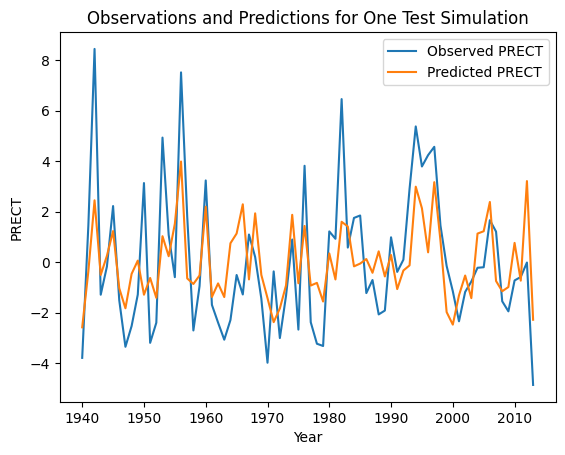

In [29]:
plt.plot(actual_pred_df['Year'], actual_pred_df['Actual PRECT'], label='Observed PRECT')
plt.plot(actual_pred_df['Year'], actual_pred_df['Predicted PRECT'], label='Predicted PRECT')
plt.xlabel('Year')
plt.ylabel('PRECT')
plt.title('Observations and Predictions for One Test Simulation')
plt.legend()
plt.show()

### Real World Test

In [30]:
ds3 = xr.open_dataset("real_world_sst.nc", decode_times=False)
#ds2 = xr.open_dataset("/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_SST.nc", decode_times=False)
ds3

<xarray.Dataset> Size: 32MB
Dimensions:  (time: 72, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 576B 0 365 730 1096 1461 ... 24837 25202 25567 25933
Data variables:
    SST      (time, lat, lon) float64 32MB ...

In [31]:
PRECT_real = pd.read_csv('real_world_prect.csv')
PRECT_real = PRECT_real.set_index(['year', 'region'])
PRECT_real.drop(columns=['Unnamed: 0'], inplace=True)
PRECT_real.tail()

,,PRECT
year,region,
2017,South,-3.404232
2018,South,3.063811
2019,South,0.466426
2020,South,-3.871161
2021,South,-2.409134


In [32]:
y= PRECT_real.to_numpy()
y.shape
(216, 1)
y = y[144:]
y.shape

(72, 1)

In [33]:
PRECT_real.iloc[144:]

,,PRECT
year,region,
1950,South,-3.861093
1951,South,3.997832
1952,South,-1.571997
1953,South,0.323647
1954,South,-1.887663
...,...,...
2017,South,-3.404232
2018,South,3.063811
2019,South,0.466426


In [34]:
X = ds3['SST'].to_numpy()
X.shape

(72, 192, 288)

In [35]:
X = X[:72, :, :]
X.shape

(72, 192, 288)

In [36]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [37]:
BATCH_SIZE = 32

X = from_numpy(X).float()
y = from_numpy(y).float()

X = X.view(-1, 192, 288)
y = y.view(-1, 1)

dataset_real = TensorDataset(X, y)
dataloader_real = DataLoader(dataset_real, batch_size=BATCH_SIZE, shuffle=False)

In [38]:
actual_values = np.array(y.squeeze(1))

model_best_weights = model_best_weights.to(device) 

# Set the model to evaluation mode
model_best_weights.eval()

predicted_values = model_best_weights(X.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()
#predicted_values = model(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()

r_squared_value = r_squared(actual_values, predicted_values)
print("R-squared:", r_squared_value)

R-squared: 0.20121270418167114


In [39]:
test_valid_loop(dataloader_real, model_best_weights, loss_fn, valid = False)

Test Loss: 9.748709 

